## Pylove example simulation

In [1]:
import sys
from os import cpu_count
sys.path.append("../")
from mappings import hubbard_mapping_helper as mapper
from mappings import gse_9_mode
import numpy as np
from simulator.logical_vector_simulator import logical_state_simulation
from simulator.noise import single_qubit_depolarizing, parallel_single_qubit_depolarizing, noiseless
from simulator.utils import check_mapping, fidelity

from time import time

The simulation is of a circuit 14-qubit encoding of a 9-mode fermionic system.

This encoding is from a family called the GSE (Generalized Superfast Encoding)

We can import the operators from the mapping file `mappings.gse_9_mode`

In [2]:
stabs = gse_9_mode.stabs
Aops = gse_9_mode.Aop
Bops = gse_9_mode.Bop
qubits = 14
# Additional operators to fix the initial state - here start in the vacuum
# We only need to include 8 Bops, they all multiply to the total parity which happens to be 
# in the stabilizer group

fixed_ops = [Bops[j] for j in range(8)] 
# Raises a simulator error if there is a commutation issue between the logical ops and the stabilizers
check_mapping(Aops,Bops,stabs) 




Let's include some noise on the qubits, in this case 
* single qubit depolarizing noise acting on idle qubits: `single_qubit_depolarizing`
* depolarizing noise acting independently in parallel on both qubits following each CNOT gate: `parallel_single_qubit_depolarizing`

We'll average over `200` noise realizations

In [3]:
cpus = 1
shots = 200

stat_noise_rate = 0.001
gate_noise_rate = 0.01
if stat_noise_rate==0.0:
    stat_noise_model = noiseless()
else:
    stat_noise_model = single_qubit_depolarizing(stat_noise_rate)
if gate_noise_rate==0.0:
    gate_noise_model = noiseless()
else:
    gate_noise_model = parallel_single_qubit_depolarizing(gate_noise_rate)


## Fidelity decay experiment

Over a range of circuit depths, track the decay of postselected fidelity given a fixed number of shots

In [4]:
# Choose the circuits to be a sequence of Aops with random angles
circuit_schedule = [
        np.random.rand()*Aops[(0,1)],
        np.random.rand()*Aops[(1,2)],
        np.random.rand()*Aops[(3,4)],
        np.random.rand()*Aops[(4,5)],
        np.random.rand()*Aops[(6,7)],
        np.random.rand()*Aops[(7,8)],
        np.random.rand()*Aops[(0,3)],
        np.random.rand()*Aops[(3,6)],
        np.random.rand()*Aops[(1,4)],
        np.random.rand()*Aops[(4,7)],
        np.random.rand()*Aops[(2,5)],
        np.random.rand()*Aops[(5,8)]
]*10

Simulation execution - takes about 175 seconds

In [5]:
fidelities = []
start = time()
for circuit_depth in range(0,50,5):
    (state, block_entries, ideal_state, depth, data)  = logical_state_simulation(
                    stabilizers = stabs,
                    n_phys_qubits = qubits,
                    rounds = shots,
                    stat_noise = stat_noise_model,
                    gate_noise = gate_noise_model,
                    phys_circuit = circuit_schedule[:circuit_depth],
                    logical_operators = fixed_ops,
                    d_matrix_blocks = 'code',
                    block_numbers = [],
                    num_processes = cpus
                    )
    fidelities.append(fidelity(state,ideal_state))
end = time()
print(f'took {end-start} seconds')

took 177.8596386909485 seconds


And let's plot the results

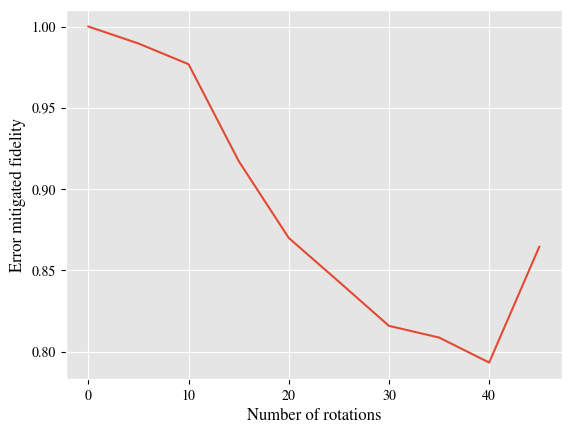

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc_file_defaults()
plt.style.use('ggplot')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.plot(range(0,50,5),fidelities)
plt.xlabel('Number of rotations',color='black')
plt.ylabel('Error mitigated fidelity',color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.show()